# Inferring an RL API from a MuJoCo Environment

**Goal**: using MuJoCo Python API, you will infer a standard RL interface for the corridor environment you played with in previous lessons.

We will explore and question the following elements:
- what can be the **action space** for the 4 wheel robot
- what can be the **state space** for corridor and 4 wheel robot
- how to evaluate a good/bad position for the robot to have a notion of reward
- what can be a **step** and what a step might do as a **function** what is the **`from`** and the **`to`**
- how to think about reward through all the steps. How to build a value function
- how to have a discount factor and link it to the notion of trade-off between exploration vs. exploitation
- `step(action)` → returns **next_state, reward, terminated, truncated, info**
- `reset()` → returns an initial **state** and **info**
- Understand and check **`terminated` vs `truncated`** (and why both exist).
- Log and visualize a **trajectory** and differentiate **state vs next_state**.
- Build the canonical training loop with `done = terminated or truncated`.
- What would be the control law for the robot, also called the **`policy`** in rl terminology ?

> You're encouraged to treat the environment as a sealed box. Your tools are prints, shapes,
> bounds, and the API surface. Infer what's going on from *observations*, not internals.

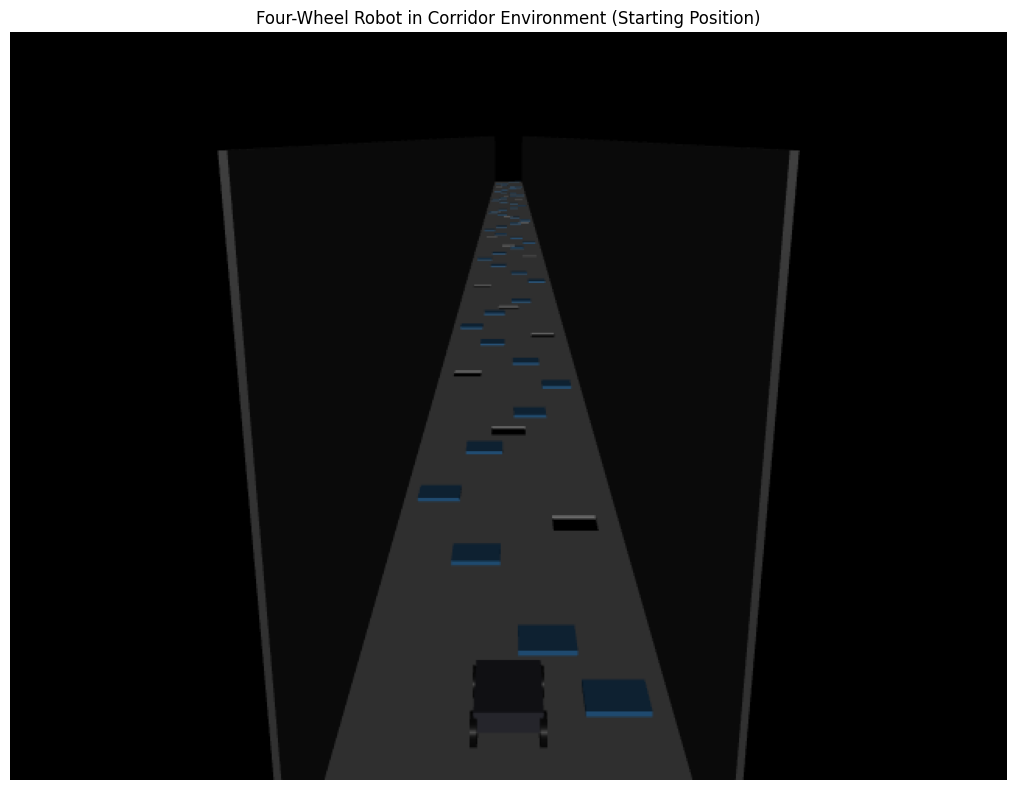

Model loaded successfully!
Number of actuators: 4
Number of generalized coordinates (nq): 11
Number of degrees of freedom (nv): 10
Robot starting position: [1.99999936e+00 1.88511030e-05 2.87026378e-01]


In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

# Define paths
corridor_path = Path("./corridor_3x100_no_full_obstacles.xml")
robot_path = Path("./four_wheel_robot.xml")

# Function to merge robot into corridor environment
def merge_robot_into_corridor(corridor_xml_path, robot_xml_path):
    """Merge the robot XML into the corridor environment."""
    
    # Parse corridor environment
    corridor_tree = ET.parse(corridor_xml_path)
    corridor_root = corridor_tree.getroot()
    
    # Parse robot definition
    robot_tree = ET.parse(robot_xml_path)
    robot_root = robot_tree.getroot()
    
    # Extract robot components
    robot_worldbody = robot_root.find('worldbody')
    robot_actuators = robot_root.find('actuator')
    robot_assets = robot_root.find('asset')
    
    # Find corridor worldbody
    corridor_worldbody = corridor_root.find('worldbody')
    
    # Add robot body to corridor (position at start of corridor)
    if robot_worldbody is not None:
        for body in robot_worldbody:
            if body.get('name') == 'robot':
                # Clone and position robot at start
                robot_body = ET.fromstring(ET.tostring(body))
                robot_body.set('pos', '2.0 0 0.2')  # Start position in corridor
                corridor_worldbody.append(robot_body)
    
    # Add robot actuators
    corridor_actuators = corridor_root.find('actuator')
    if corridor_actuators is None:
        corridor_actuators = ET.SubElement(corridor_root, 'actuator')
    if robot_actuators is not None:
        for actuator in robot_actuators:
            corridor_actuators.append(ET.fromstring(ET.tostring(actuator)))
    
    # Add robot materials to assets
    corridor_assets = corridor_root.find('asset')
    if robot_assets is not None:
        for material in robot_assets.findall('material'):
            # Check if material already exists
            mat_name = material.get('name')
            existing = corridor_assets.find(f".//material[@name='{mat_name}']")
            if existing is None:
                corridor_assets.append(ET.fromstring(ET.tostring(material)))
    
    # Add a camera for nice overhead view
    # Check if worldbody has a camera, if not add one
    existing_camera = corridor_worldbody.find(".//camera[@name='tracking']")
    if existing_camera is None:
        camera = ET.Element('camera')
        camera.set('name', 'tracking')
        camera.set('mode', 'trackcom')
        camera.set('pos', '-5 0 5')
        camera.set('xyaxes', '0 -1 0 0.3 0 1')
        corridor_worldbody.append(camera)
    
    # Convert to string
    return ET.tostring(corridor_root, encoding='unicode')

# Merge the XMLs
merged_xml = merge_robot_into_corridor(corridor_path, robot_path)

# Load model from merged XML string
model = mujoco.MjModel.from_xml_string(merged_xml)
data = mujoco.MjData(model)

# Reset to initial state
mujoco.mj_resetData(model, data)

# Create renderer
renderer = mujoco.Renderer(model, height=480, width=640)

# Step simulation a few times to let physics settle
for _ in range(10):
    mujoco.mj_step(model, data)

# Update scene and render with tracking camera
renderer.update_scene(data, camera="tracking")
pixels = renderer.render()

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(pixels)
plt.axis('off')
plt.title('Four-Wheel Robot in Corridor Environment (Starting Position)')
plt.tight_layout()
plt.show()

print(f"Model loaded successfully!")
print(f"Number of actuators: {model.nu}")
print(f"Number of generalized coordinates (nq): {model.nq}")
print(f"Number of degrees of freedom (nv): {model.nv}")
print(f"Robot starting position: {data.qpos[:3]}")

## Action Space

In reinforcement learning, the **action space** defines what actions an agent can take to interact with the environment. For our 4-wheel robot, we need to understand how to control it.

### Question 1: How many actuators does the robot have?

- Use `model.nu` to find the number of actuators

The "nu" naming comes from MuJoCo's convention where **`nq`** = number of generalized coordinates (positions), **`nv`** = number of degrees of freedom (velocities), and **`nu`** = number of actuator controls (inputs). The "u" represents the control input vector in control theory notation, where dynamics are typically written as $\dot{x} = f(x, u)$. The "n" prefix means "number of", so `nu` = "number of controls".

- Print the actuator names using `model.actuator(i).name` for each actuator
- What do these actuators control?

In [ ]:
# TODO: Question 1 - Explore actuators


### Question 2: What are the control ranges for each actuator?

- Check `model.actuator_ctrlrange` to see the min/max control values
- What do these ranges tell you about how the robot can move?

In [ ]:
# TODO: Question 2 - Check control ranges


### Question 3: How do we send commands to the actuators?

- Look at `data.ctrl` - what is its shape and what does it represent?
- Try setting `data.ctrl[:] = [1.0, 1.0, 1.0, 1.0]` and stepping the simulation a few times
- What happens to the robot? Can you visualize it?

In [ ]:
# TODO: Question 3 - Send commands and visualize
# 1) print command shape

# 2) print command initial values

# 3) Reset the simulation

# 4) Set all wheels to spin forward at 1.0 rad/s

# 5) Do 800 steps of the simulation and render the new state


## State Space

In reinforcement learning, the **state space** defines all the information an agent can observe about the environment. For our corridor navigation task, we need to identify what information is relevant for the robot to make good decisions.

Let's explore different components of the state space.

### Question 4: What describes the robot's internal state?

The robot has its own physical state independent of the corridor.

- Look at `data.qpos` - what is its shape? What does each element represent?
- Look at `data.qvel` - what is its shape? What does each element represent?
- Print these arrays and try to understand: which values correspond to the robot's position, orientation, and wheel states?
- How many total state variables describe the robot itself?

In [ ]:
# TODO: Question 4 - Explore robot state

# Positions (generalized coordinates) describes dimensions such as x, y, z, and orientations

# Velocities (generalized velocities) describes dimensions such as linear and angular velocities


### Question 5: What is the robot's position in the corridor?

For navigation, we need to know where the robot is in the corridor coordinate system.

- Extract the robot's (x, y, z) position from `data.qpos` (hint: usually the first 3 elements for free-floating bodies)
- The corridor extends along the x-axis. What is the robot's current x-position?
- How far has the robot traveled from the start (x ≈ 0)?
- If the corridor is 100m long, how would you compute the remaining distance to the goal?

In [ ]:
# TODO: Question 5 - Explore robot position in corridor

# Extract robot position
robot_x, robot_y, robot_z = 0.0, 0.0, 0.0
print(f"Robot current x-position: {robot_x:.2f}m")

# Corridor parameters
corridor_start = 0.0
corridor_length = 100.0
corridor_end = corridor_start + corridor_length

print(f"Corridor: start at x={corridor_start:.1f}m, end at x={corridor_end:.1f}m")

# TODO: compute distance traveled and remaining distance
travel_distance = 0.0
print(f"Distance traveled from start: {travel_distance:.2f}m")
remaining_distance = 0.0
print(f"Remaining distance to goal: {remaining_distance:.2f}m")
progress_percent = 0.0
print(f"Progress: {progress_percent:.2f}%")

### Question 6: What sensory information about the floor is available?

The corridor has different floor types: **flat** (safe), **bumps** (obstacles), and **holes** (dangerous). The robot needs to "sense" what's around it.

The corridor is **100m long** and **3m wide**. It is divided into **rows** along the x-axis, where each row is **0.5 meter long** and spans the full width of the corridor. Each row contains **6 cells** across the width (y-axis), with each cell being **0.5m × 0.5m**. Each cell can be one of three types:
- **Flat** (0): Normal floor, safe to traverse
- **Bump** (1): Raised obstacle, may slow or destabilize the robot  
- **Hole** (2): Gap in the floor, robot would fall through

**Corridor structure**: For a row at position x, the 6 cells are:
- Cell at (y₀, x): leftmost cell
- Cell at (y₁, x): left cell
- Cell at (y₂, x): center-left cell
- Cell at (y₃, x): center-right cell
- Cell at (y₄, x): right cell
- Cell at (y₅, x): rightmost cell

where y₀, y₁, y₂, y₃, y₄, y₅ span the 3m width of the corridor (each cell is 0.5m wide).

**Sensory window concept**: Consider the robot can observe floor cells in rows around its position:
- **Row ahead**: the 6 cells at x + 0.5m: (y₀, x+0.5), (y₁, x+0.5), ..., (y₅, x+0.5)
- **Row under**: the 6 cells at x: (y₀, x), (y₁, x), ..., (y₅, x)
- **Row behind**: the 6 cells at x - 0.5m: (y₀, x-0.5), (y₁, x-0.5), ..., (y₅, x-0.5)

Tasks:
- Based on the robot's x-position, calculate which corridor row it's currently in (hint: `row_index = int(x_position / 0.5)`)
- If you observe 3 rows (1 ahead, 1 under, 1 behind) with 6 cells each, how many total cells do you observe? (3 × 6 = 18 cells)
- How would you represent this as a state vector? What would be its shape?
- Each cell has 3 possible values (flat/bump/hole). How would you encode this information?

In [ ]:
# TODO: Question 6 - Explore sensory information about floor cells

# Calculate current row from qpos

# Calculate current column from qpos

# Corridor structure
corridor_length = 100.0  # meters
corridor_width = 3.0  # meters
cell_width = 0.5  # meters (0.5m × 0.5m cells)
n_cells_per_row = 6  # 3m width / 0.5m = 6 cells per row

print(f"Corridor structure:")
print(f"  - Length: {corridor_length}m")
print(f"  - Width: {corridor_width}m")
print(f"  - Cell size: {cell_width}m × {cell_width}m")
print(f"  - Cells per row: {n_cells_per_row}")
print(f"  - Row length: {cell_width}m")
print()

# Define observation window: 3 rows (behind, under, ahead)
rows_to_observe = [-1, 0, 1]  # relative to current row

# Example: create a mock observation (in real implementation, this would come from the environment)
# Cell types: 0=flat, 1=bump, 2=hole
# What is its shape?

### Question 7: How to extract cell states from MuJoCo?

In Question 6, we discussed the **concept** of observing floor cells. Now we need to **implement** it - how do we actually get this information from MuJoCo?

**The challenge**: MuJoCo simulates physics, but the corridor XML contains geometric information about bumps and holes. We need to bridge these two representations.

**Exploration tasks**:

1. **Investigate the corridor XML structure**:
   - The corridor was loaded from `corridor_3x100_no_full_obstacles.xml`
   - Look at the merged XML string we created: `merged_xml`
   - What elements in the XML represent the floor? Look for `<geom>` elements in the worldbody
   - Can you identify which geoms are bumps, holes, or flat sections?

2. **Understand MuJoCo's naming system** (semantic approach):
   - Use `model.ngeom` to see how many geometries exist in the model
   - Use `model.geom(i).name` to iterate through geometry names
   - Can you find geometries related to the corridor floor? (hint: look for names containing "cell", "bump", "hole", "flat")

3. **Extract position information**:
   - Each floor geometry has a position in the world
   - Try using `model.geom(i).pos` to get a geometry's position (this might not work directly)
   - Alternative: Use `data.geom_xpos[i]` to get the position of geometry `i` as (x, y, z)
   - Given the robot's position and a floor geometry's position, can you determine if it's in the observation window?

4. **Geometric detection method** (collision-based approach):
   - Instead of relying on names, use MuJoCo's collision detection to probe the floor
   - **Detecting bumps**: Create a small test box slightly above the ground (e.g., z=0.05) at position (x, y). Use `mujoco.mj_collideGeoms()` or ray casting to check for collision. A bump will collide with this box.
   - **Detecting holes**: Create a small test box at ground level (z=0) centered in the cell. Check for collision with the floor geometry. No collision = hole (floor is missing).
   - **Flat surface**: Collision at ground level but not above = flat floor
   - This approach is more robust and doesn't depend on naming conventions

5. **Design a function**:
   - How would you create a function `get_floor_observation(robot_x, robot_y, n_rows_ahead, n_rows_behind)` that:
     - Finds all floor geometries within the observation window (or probes each cell position)
     - Determines their cell type using either semantic (names) or geometric (collision) methods
     - Returns a structured array representing the local floor state

**Hints**:
- **Semantic method**: Geometry names often encode information (e.g., "cell_bump_x5_y2")
- **Geometric method**: Use `mujoco.mj_ray()` to cast rays downward at cell centers, or create temporary collision geometries
- Consider: should you parse once at initialization (semantic) or query each time (geometric)?
- The geometric method is more general but may be slower; the semantic method is faster but requires consistent naming

In [ ]:
# Question 7 - Extract cell states from MuJoCo


print("=== Extracting Floor Cell Information from MuJoCo ===\n")

# 1) Explore the model's geometries
print(f"Total number of geometries: {model.ngeom}")
print("\nFirst 20 geometry names:")
# TODO: print first 20 geometry names

# 2) Find floor-related geometries and understand naming convention
print("APPROACH 1: SEMANTIC METHOD (using geometry names)\n")
print("Floor geometries (filtering for 'cell' in name):")
# TODO: find the number of floor geometries

# 3a) Semantic approach: Design a way to map geometries to the cell grid structure using names
print("Building cell type lookup table from names...")
print("Assuming naming convention: names contain 'bump', 'hole', or default to 'flat'\n")

# TODO update the function
def get_cell_type_from_name(name):
    """Determine cell type from geometry name."""
    name_lower = name.lower()
    if 'bump' in name_lower:
        return -1  # bump
    elif 'hole' in name_lower:
        return -1  # hole
    else:
        return -1  # flat (default)


cell_map_semantic = {}
# TODO Build a spatial index: map (row, col) -> cell_type
print(f"\nBuilt semantic lookup table with {len(cell_map_semantic)} cells")
print("\n" + "="*70 + "\n")

# 3b) Geometric approach: Use collision detection to probe each cell
#     - Ray casting or collision queries at different heights
#     - Detect bumps (collision slightly above ground)
#     - Detect holes (no collision at ground level)


print("APPROACH 2: GEOMETRIC METHOD (using collision detection)\n")
print("Using MuJoCo ray casting to detect floor type at specific positions...")

def detect_cell_type_geometric(x, y, z_ground=0.0, z_bump_test=0.1):
    """
    Detect cell type using geometric probing with ray casting.
    
    Args:
        x, y: World coordinates of the cell center
        z_ground: Ground level height
        z_bump_test: Height to test for bumps
    
    Returns:
        0=flat, 1=bump, 2=hole
    """
    # Cast ray downward from above to detect ground
    ray_start = np.array([x, y, 1.0], dtype=np.float64)  # Start from above
    ray_direction = np.array([0.0, 0.0, -1.0], dtype=np.float64)  # Point downward
    
    # Prepare output array for geom_id (must be writable, shape [1,1], dtype int32)
    geom_id_array = np.array([[-1]], dtype=np.int32)
    
    # Use mj_ray to find first collision
    # Returns distance to collision (or -1 if no collision)
    distance = mujoco.mj_ray(model, data, ray_start, ray_direction, 
                              None, 1, -1, geom_id_array)
    
    geom_id = geom_id_array[0, 0]
    
    if geom_id == -1 or distance < 0:
        # TODO what to return here?
        return None
    
    # Now test for bump: cast ray from slightly above ground
    ray_start_low = np.array([x, y, z_bump_test], dtype=np.float64)
    geom_id_bump_array = np.array([[-1]], dtype=np.int32)
    
    distance_bump = mujoco.mj_ray(model, data, ray_start_low, ray_direction,
                                   None, 1, -1, geom_id_bump_array)
    
    geom_id_bump = geom_id_bump_array[0, 0]
    
    if geom_id_bump != -1 and distance_bump > 0 and distance_bump < 0.5:
        # TODO what to return here?
        return None
    else:
        # TODO what to return here?
        return None

# 4) Implement a function to get observation around the robot
print("Implementing observation function (using semantic method)...\n")

def get_floor_observation(robot_x, robot_y, n_rows_ahead=1, n_rows_behind=1, n_cols=6):
    """
    Get floor cell observations around the robot.
    
    Args:
        robot_x: Robot's x position
        robot_y: Robot's y position
        n_rows_ahead: Number of rows to observe ahead
        n_rows_behind: Number of rows to observe behind
        n_cols: Number of columns (cells per row) - updated to 6
    
    Returns:
        2D numpy array of shape (n_rows_behind + 1 + n_rows_ahead, n_cols)
        with cell types: 0=flat, 1=bump, 2=hole
    """
    #TODO implement it
    return None

# Test the observation function
robot_x = data.qpos[0]
robot_y = data.qpos[1]

observation = get_floor_observation(robot_x, robot_y, n_rows_ahead=1, n_rows_behind=1)

print("Floor observation around robot:")
print(f"Robot at x={robot_x:.2f}, y={robot_y:.2f}")
print(f"Observation shape: {observation.shape} (rows × cols)")
print(f"\nObservation array:")
print(observation)
print("\nRow interpretation:")
print(f"  Row 0 (behind, x≈{int(robot_x / cell_width) - 1} × 0.5m = {(int(robot_x / cell_width) - 1) * 0.5:.1f}m): {observation[0]}")
print(f"  Row 1 (under,  x≈{int(robot_x / cell_width)} × 0.5m = {int(robot_x / cell_width) * 0.5:.1f}m):   {observation[1]}")
print(f"  Row 2 (ahead,  x≈{int(robot_x / cell_width) + 1} × 0.5m = {(int(robot_x / cell_width) + 1) * 0.5:.1f}m): {observation[2]}")
print("\n(0=flat, 1=bump, 2=hole)")

### Question 8: How does the state space size grow with observation window?

The size of the state space has huge implications for learning complexity.

Remember: the corridor is 100m long and 3m wide, divided into 0.5m × 0.5m cells. Each row (0.5m along x-axis) has **6 cells** across the 3m width. Consider different observation windows:
- **Minimal**: Only the row directly under the robot (1 row × 6 cells = 6 cells)
- **Local**: 1 row ahead, 1 under, 1 behind (3 rows × 6 cells = 18 cells)
- **Extended**: 3 rows ahead, 1 under, 3 behind (7 rows × 6 cells = 42 cells)
- **Full corridor**: All 200 rows (100m / 0.5m = 200 rows × 6 cells = 1200 cells)

Tasks:
- If each cell can be in 3 states (flat/bump/hole), how many possible combinations exist for:
  - 6 cells? (3^6 = ?)
  - 18 cells? (3^18 = ?)
  - 42 cells? (3^42 = ?)
  - 1200 cells? (3^1200 = ?)
- If we include continuous robot state (position, angle, wheel velocities), what would be the overall state space?
- Is the state space discrete or continuous?
- What's the trade-off between a larger observation window (more information) vs a smaller one (simpler learning)?

In [ ]:
# Question 8 - Calculate state space complexity

print("=== State Space Complexity ===\n")

# Calculate combinatorial explosion
# Corridor: 100m long × 3m wide, cells are 0.5m × 0.5m
# Each row is 0.5m long and contains 6 cells across the width
corridor_length = 100.0  # meters
corridor_width = 3.0  # meters
cell_size = 0.5  # meters (0.5m × 0.5m)
cells_per_row = 6  # 3m / 0.5m = 6 cells
total_rows = int(corridor_length / cell_size)  # 100m / 0.5m = 200 rows

observation_configs = [
    ("Minimal (1 row)", 1, cells_per_row * 1),
    ("Local (3 rows)", 3, cells_per_row * 3),
    ("Extended (7 rows)", 7, cells_per_row * 7),
    ("Full corridor (200 rows)", total_rows, cells_per_row * total_rows)
]

print(f"Corridor: {corridor_length}m long × {corridor_width}m wide")
print(f"Cell size: {cell_size}m × {cell_size}m")
print(f"Each row is {cell_size}m long and has {cells_per_row} cells across the width.")
print(f"Total rows in corridor: {total_rows} rows")
print("\nIf each cell has 3 possible states (flat/bump/hole):\n")

for name, n_rows, n_cells in observation_configs:
    #TODO compute n_combinations
    n_combinations = 0
    print(f"{name:35s}: {n_rows} rows × {cells_per_row} cells = {n_cells} cells")
    print(f"{'':35s}   3^{n_cells} = {n_combinations:,.0f} combinations")
    
    if n_cells <= 42:
        print(f"{'':35s}   ({n_combinations:,.0f} discrete states)")
    else:
        print(f"{'':35s}   ({n_combinations:.2e} - astronomical!)")
    print()

print("\n" + "="*70 + "\n")
print("State space characteristics:")
print()
print("FLOOR OBSERVATION ONLY (discrete):")
print(f"  - For local window (18 cells): {3**18:,} possible floor configurations")
print(f"  - This is manageable for lookup tables")
print()
print("ROBOT STATE (continuous):")
print(f"  - Position: (x, y) - 2 continuous dimensions")
print(f"  - Orientation: (θ) - 1 continuous dimension")
print(f"  - Velocities: (vx, vy, ω) - 3 continuous dimensions")
print(f"  - Total robot state: ~6+ continuous dimensions")
print()
print("COMBINED STATE SPACE (hybrid):")
print(f"  - Discrete floor observation × Continuous robot state")
print(f"  - This is a HYBRID state space (discrete + continuous)")
print(f"  - Total: INFINITE (due to continuous components)")
print()
print("💡 KEY INSIGHT: Trade-offs")
print()
print("LARGER OBSERVATION WINDOW:")
print("  ✅ More information → better planning")
print("  ✅ Can see obstacles further ahead")
print("  ❌ Exponentially larger state space")
print("  ❌ Harder to learn (more data needed)")
print()
print("SMALLER OBSERVATION WINDOW:")
print("  ✅ Smaller state space → faster learning")
print("  ✅ Less memory/computation required")
print("  ❌ Limited \"vision\" → reactive only")
print("  ❌ Can't plan ahead effectively")
print()
print("🎯 PRACTICAL APPROACH:")
print("  - Use function approximation (neural networks) instead of lookup tables")
print("  - This handles continuous states AND large discrete spaces")
print("  - Local observation window (3-7 rows) is usually sufficient")

### Question 9: How do we detect terminal conditions?

The episode should end when certain conditions are met. We need to distinguish between **success** and **failure**.

The corridor starts at **x = 0** and ends at **x = L** (e.g., L = 100m for a 100m corridor).

**Terminal conditions to consider**:
- **Success**: Robot reaches the end of the corridor (x ≥ L)
- **Failure**: Robot falls in a hole (z-position drops below threshold, e.g., z < 0)

Tasks:
- How would you check if the robot reached the goal? (hint: check x-position in `data.qpos`)
- How would you detect if the robot fell in a hole? (hint: check z-position)
- In RL terminology, these conditions set the `terminated` flag to `True`. Why is it important to distinguish between success termination vs failure termination?
- Can you implement a check function taking the robot's state and returning `terminated` and `truncated` flag
- Define a `reward`: a floating number for reaching the goal vs falling in a hole?
- Can you implement a reward function taking as input the robot's state and returning the appropriate reward?s?

In [ ]:
# Question 9 - Detect terminal conditions

print("=== Terminal Condition Detection ===\n")

# Define corridor parameters
CORRIDOR_LENGTH = 100.0
CORRIDOR_WIDTH = 3.0  # 3 meters wide

# Implement a check function
def check_terminal_conditions(robot_state):
    """
    Check if robot has reached a terminal state.
    
    Args:
        robot_state: Dictionary or tuple with robot position information
        
    Returns:
        terminated: Boolean - True if episode ended naturally (success or failure)
        truncated: Boolean - True if episode was cut short (not used here, for completeness)
        info: Dictionary with diagnostic information
    """
    # Extract positions
    if isinstance(robot_state, dict):
        robot_x = robot_state['x']
        robot_y = robot_state['y']
        robot_z = robot_state['z']
    else:
        robot_x = robot_state[0]
        robot_y = robot_state[1]
        robot_z = robot_state[2]
    
    # Initialize
    terminated = False
    truncated = False  # Not used for natural termination
    info = {
        'position': (robot_x, robot_y, robot_z),
        'distance_to_goal': max(0, corridor_length - robot_x),
    }
    
    # TODO Create terminal conditions
    if False: #TODO what to put here?
        # Success: reached goal (must be beyond the end of the corridor)
        terminated = True
        info['success'] = True
        info['termination_reason'] = 'reached_goal'
    elif False: #TODO what to put here?
        # Failure: fell in hole (z position too low but still within corridor)
        terminated = True
        info['success'] = False
        info['termination_reason'] = 'fell_in_hole'
    
    return terminated, truncated, info

# TODO Implement a reward function
def compute_reward(robot_state):
    """
    Compute reward based on robot state and terminal conditions.
    
    Args:
        robot_state: Dictionary or tuple with keys/indices for x, y, z positions
        
    Returns:
        reward: Float reward value
    """
    # Extract positions (handle both dict and array-like inputs)
    if isinstance(robot_state, dict):
        robot_x = robot_state['x']
        robot_y = robot_state['y']
        robot_z = robot_state['z']
    else:
        robot_x = robot_state[0]
        robot_y = robot_state[1]
        robot_z = robot_state[2]
    
    # Check terminal conditions and assign rewards
    # Use check_terminal_conditions function
    terminated, _, _ = check_terminal_conditions(robot_state)
    
    # Success: reached goal (must be beyond the end of the corridor)
    if False: #TODO what to put here?
        return +100.0, True, "SUCCESS: Reached goal!"
    
    # Failure: fell in hole or at the start of corridor
    elif False: #TODO what to put here?
        return -100.0, True, "FAILURE: Fell in hole!"
    
    # Episode continues 
    else:
        r = 0.0 # TODO what to put here?
        return r, False, None





# Test the functions with current robot state
print("Testing reward and check functions:\n")

# Get current robot state
robot_state = {
    'x': data.qpos[0],
    'y': data.qpos[1],
    'z': data.qpos[2]
}

print(f"Current robot position: x={robot_state['x']:.2f}m, y={robot_state['y']:.2f}m, z={robot_state['z']:.2f}m\n")

# Test reward function
reward, terminated, reason = compute_reward(robot_state)
print("Reward Function Output:")
print(f"  Reward: {reward:+.2f}")
print(f"  Terminated: {terminated}")
if reason:
    print(f"  Reason: {reason}")
print()

# Test check function
terminated, truncated, info = check_terminal_conditions(robot_state)
print("Check Function Output:")
print(f"  Terminated: {terminated}")
print(f"  Truncated: {truncated}")
print(f"  Info: {info}")
print()

# Test with various scenarios
print("=" * 70)
print("Testing various scenarios:\n")

test_scenarios = [
    ({'x': 100.0, 'y': 0.0, 'z': 0.15}, "At goal"),
    ({'x': 50.0, 'y': 0.0, 'z': -1.0}, "Fell in hole"),
    ({'x': 30.0, 'y': 0.0, 'z': 0.15}, "Normal state (continuing)"),
    ({'x': -2.0, 'y': 0.0, 'z': 0.15}, "Went too far backward"),
]

for state, description in test_scenarios:
    reward, term, reason = compute_reward(state)
    print(f"{description:30s} → reward={reward:+7.2f}, terminated={term}, reason: {reason}")

## Definition of step, the notion of progress

Our strategy will be a sequence of controls reacting to input from the environment and our knowledge of the robot state.

### Question 10: Implementing a step function

The `step()` function is the core of an RL environment. It takes an action, updates the simulation, and returns the new state along with reward and termination information.

Tasks:
- Write a first `step` function that takes as input:
  - The robot state (from `data.qpos` and `data.qvel`)
  - An action (control commands for the actuators)
  - A number `n_sim_steps` of simulation steps to execute
- The function should:
  - Apply the action to the actuators (`data.ctrl`)
  - Execute `n_sim_steps` MuJoCo simulation steps (`mujoco.mj_step()`)
  - Return the new robot state
- Answer these questions:
  - What is the time link between a simulation step and the time step of our function?
  - What is the dynamic of the robot during our function step?
  - If MuJoCo's timestep is `model.opt.timestep` seconds, and we run `n_sim_steps` steps, how much simulation time passes?

In [ ]:
# TODO: Question 10 - Implementing a step function



## Intermediate and long term reward

In reinforcement learning, we need to think beyond immediate rewards. How do we evaluate long-term progress and accumulate rewards over time?

### Question 11: Progress-based rewards and value functions

**Part A: Progress-based reward function**

Our current reward only gives feedback at terminal states (success/failure). We can improve this by rewarding intermediate progress.

Tasks:
- How could you integrate robot progress to have intermediate reward and favor robot progression? Write a new reward function `reward_p1` that takes into account the robot's progress along the corridor
- Did you take into account the fact that robot could go backward? Write a new function `reward_p2`, if you penalized going backward in `reward_p1`, rename it into `reward_p2`, and create a `reward_p1` that did not penalize going backward. If you did not penalize going backward in `reward_p1`, your `reward_p2` should penalize the robot if it is going backward.
- Consider: should you reward absolute position, or change in position (delta)?

**Part B: Value function and reward accumulation**

Suppose we don't know the corridor length. To favor progression, we could accumulate rewards over time.

Tasks:
- Why would accumulating rewards help favor progression?
- What is a **value function** in RL? How does it relate to future rewards?
- Write a value function that:
  - Takes as input: previous reward, previous state, action
  - Uses the step function and reward function
  - Computes a value that considers both immediate and future rewards
  
**Hint**: The value function $V(s)$ represents the expected cumulative reward from state $s$. A simple approach: $V(s) = r_t + \gamma \cdot V(s')$ where $\gamma$ is a discount factor (typically 0.9-0.99) that weighs future rewards.

In [ ]:
# TODO: Question 11 - Progress-based rewards and value functions

# Part A: Write progress-based reward functions

# reward_p1: Does not penalize backward movement


# reward_p2: Penalizes backward movement


# Part B: Write a value function that accumulates rewards



## Trajectory: what happens with the accumulation of rewards

### Question 12: Comparing value accumulation with different reward functions

Compare accumulation of rewards (the value function) taking progress into account or not by creating a trajectory by hand.

You can use the previous corridor tutorial to control the robot by hand and save the following data (output control to a file for instance):

**Recording a complete trajectory loop:**

0. **Record the initial position** (starting point)
1. **Forward traversal**: Create an array of controls that allows the robot to traverse the corridor and stop before falling at the end
2. **Record your end position** (just before the edge)
3. **Fall**: Create an array of controls to continue and fall at the end of the corridor
4. **Turn around**: Reset to the end position recorded and create an array of controls that makes the robot turn around
5. **Record the new position** facing backward
6. **Backward traversal**: Create an array of controls that makes the robot go from the end of the corridor to the start (going backwards)
7. **Return to start**: Create an array of controls that make the robot reach (as close as possible) to the initial position

**Analysis tasks:**

- You have created a loop: plot the value function with the different rewards (`reward_p1` and `reward_p2`) across multiple loops with a final fall at the end
- Compare how the accumulated value evolves differently with:
  - Simple terminal reward only
  - `reward_p1` (progress-based, no backward penalty)
  - `reward_p2` (progress-based, with backward penalty)
- Change the final reward value when the robot has its final fall (try -100, -50, -10) and observe how it affects the accumulated value throughout the trajectory
- Which reward function best reflects the quality of your trajectory?

**Hints:**
- Save your control sequences to files (e.g., `forward_controls.npy`, `backward_controls.npy`)
- Use `np.cumsum()` to compute cumulative rewards
- Create multiple subplots to compare different reward functions side-by-side

In [ ]:
# TODO: Question 12 - Trajectory analysis with value accumulation

# Step 1: Record or load control sequences
# You can create these manually or load from previous sessions

# Step 2: Simulate trajectory and compute rewards at each step

# Step 3: Compute cumulative rewards for different reward functions

# Step 4: Plot comparison of accumulated values



## The discount factor

In the previous questions, we accumulated rewards equally across time. However, in reinforcement learning, we often care more about immediate rewards than distant future rewards. This is where the **discount factor** γ (gamma) comes in.

### Understanding discounted value

Instead of simply summing rewards:
$$V = r_0 + r_1 + r_2 + r_3 + ...$$

We apply exponential discounting:
$$V = r_0 + \gamma r_1 + \gamma^2 r_2 + \gamma^3 r_3 + ...$$

where:
- γ = 1.0: No discounting (future = present)
- γ = 0.95: Future rewards worth 95% of present
- γ = 0.9: Future rewards worth 90% of present  
- γ = 0.0: Only immediate reward matters

**Why discount?**
1. **Uncertainty**: Future is uncertain, prefer rewards now
2. **Time preference**: Earlier success is better than later success
3. **Mathematical convenience**: Ensures finite values for infinite horizons
4. **Exploration vs Exploitation trade-off**: Lower γ → more myopic → more exploitation

### Question 13: Visualizing the impact of γ

**Part A: Real-time discount factor visualization**

Integrate real-time plotting of the accumulated discounted value into the manual control script (`t01_4_wheels_robot_pilot.py`). The plot should update continuously while you control the robot.

**Part B: Comparing different γ values**

Create a static visualization comparing trajectories with different discount factors:
- γ = 1.0 (no discounting)
- γ = 0.95 (typical RL value)
- γ = 0.9 (more myopic)
- γ = 0.5 (very short-sighted)

Use the same control sequence from Question 12. Plot the accumulated value over time for each γ, showing how the discount factor changes the value accumulation curve.

**Hints:**
- For real-time plotting: Use `matplotlib.pyplot.ion()` for interactive mode, update the plot inside the control loop
- The discounted value at step t: $V_t = \sum_{k=0}^{t} \gamma^k r_k$
- You may want to add this feature to a copy of `t01_4_wheels_robot_pilot.py` to avoid modifying the original

In [ ]:
# TODO: Question 13 - Discount factor visualization

# Part A: Real-time plotting integration
# 1. Create a modified version of t01_4_wheels_robot_pilot.py with real-time value plotting
# 2. Add matplotlib figure with ion() for interactive mode
# 3. Update plot in control loop to show accumulated discounted value
# 4. Use gamma = 0.95

# Part B: Compare different gamma values
# 1. Load the saved control sequence from Question 12
# 2. For each gamma in [1.0, 0.95, 0.9, 0.5]:
#    - Simulate trajectory with saved controls
#    - Compute discounted cumulative rewards
# 3. Plot all curves on same figure to compare
# 4. Add legend showing gamma values

## Canonical RL API: Standardizing the Environment Interface

So far, we've been directly interacting with MuJoCo's API. However, reinforcement learning frameworks (like OpenAI Gym, Gymnasium) define a **standard interface** that all environments should follow. This standardization allows RL algorithms to work with any environment without modification.

### The Canonical `step()` Function

The step function is the heart of any RL environment. It takes an action and returns the consequences:

```python
next_state, reward, terminated, truncated, info = env.step(action)
```

**Return values explained:**

1. **`next_state`** (observation): The new state after taking the action
   - Should be a numpy array with consistent shape
   - Contains all information the agent needs to make decisions

2. **`reward`** (float): The immediate reward for this transition
   - Scalar value (single number)
   - Defines what the agent should optimize

3. **`terminated`** (bool): Episode ended due to task completion
   - `True`: Agent reached a **terminal state** (success or failure inherent to the task)
   - Examples: Robot fell off, reached goal, died
   - The episode is **truly over** - continuing doesn't make sense

4. **`truncated`** (bool): Episode ended due to external constraint
   - `True`: Episode cut short by **time limit** or **boundary condition**
   - Examples: Maximum steps reached, out of bounds, timeout
   - The episode was **artificially stopped** - task could theoretically continue

5. **`info`** (dict): Additional diagnostic information
   - Optional metadata about the transition
   - Not used for learning, only for debugging/logging
   - Common entries:
     - `"success"`: Boolean indicating task success
     - `"distance_to_goal"`: Auxiliary metric
     - `"cell_type"`: Which cell the robot is on
     - `"velocity"`: Current speed
     - `"collision"`: Whether collision occurred

**Why separate `terminated` vs `truncated`?**

This distinction is crucial for proper value function learning:
- **`terminated=True`**: The value of the next state is truly 0 (episode over naturally)
- **`truncated=True`**: The next state still has value (we just stopped observing)

In algorithms like Q-learning:
- If `terminated`: Q(s', a') term is zero
- If `truncated`: Q(s', a') should be estimated (episode continues in principle)

### The Canonical `reset()` Function

Before starting a new episode, we need to reset the environment:

```python
initial_state, info = env.reset()
```

**Return values:**

1. **`initial_state`** (observation): Starting state for the new episode
   - Same shape and type as states returned by `step()`
   - Should be deterministic or randomly sampled from initial state distribution

2. **`info`** (dict): Initial diagnostic information
   - Similar to `step()` info dict
   - Can contain initial conditions, random seed, etc.

### The Canonical Training Loop

With these two functions, the standard RL training loop looks like:

```python
# Episode loop
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    episode_reward = 0
    
    # Step loop
    while not done:
        # Agent selects action
        action = agent.select_action(state)
        
        # Environment steps
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # Check if episode is over
        done = terminated or truncated
        
        # Agent learns from transition
        agent.learn(state, action, reward, next_state, terminated)
        
        # Update state and accumulate reward
        state = next_state
        episode_reward += reward
        
        # Optional: render, log, etc.
        if render:
            env.render()
    
    print(f"Episode {episode}: Total Reward = {episode_reward}")
```

**Key points:**

1. **`done = terminated or truncated`**: Episode ends for either reason
2. **Pass `terminated` to learning**: Algorithm needs to know if next_state has value
3. **Don't confuse `done` with `terminated`**: They mean different things!
4. **`info` is for you, not the agent**: Don't use it for decision-making (that's cheating!)

### Question 14: Implement the Canonical API

Wrap our MuJoCo corridor environment in a class with canonical `step()` and `reset()` methods:

**Your tasks:**

**Part A: Implement `step(action)`**
- Input: `action` (numpy array of wheel controls)
- Output: `(next_state, reward, terminated, truncated, info)`
- Use `reward_p2` (progress-based with backward penalty)
- Set `terminated=True` when robot falls off corridor
- Set `truncated=True` when max_steps reached (e.g., 1000 steps)
- Include useful information in `info` dict

**Part B: Implement `reset()`**
- Input: None (or optional seed for reproducibility)
- Output: `(initial_state, info)`
- Reset MuJoCo simulation to start position
- Return initial observation

**Part C: Test with the canonical training loop**
- Implement a simple random agent
- Run 5 episodes with the canonical loop structure
- Print episode statistics (length, total reward, termination reason)
- Verify that `terminated` and `truncated` are set correctly

**Hints:**
- Store `model` and `data` as instance attributes
- Keep a step counter for truncation
- The `info` dict is your friend for debugging!

In [ ]:
# TODO: Question 14 - Implement canonical RL API

class CorridorEnv:
    """Canonical RL environment wrapper for MuJoCo corridor."""
    
    def __init__(self, xml_path="four_wheel_robot.xml", max_steps=1000):
        """Initialize the environment.
        
        Args:
            xml_path: Path to MuJoCo XML file
            max_steps: Maximum steps before truncation
        """
        # TODO: Initialize MuJoCo model and data
        # TODO: Store max_steps
        # TODO: Initialize step counter
        pass
    
    def reset(self, seed=None):
        """Reset environment to initial state.
        
        Args:
            seed: Optional random seed for reproducibility
            
        Returns:
            initial_state: Initial observation (numpy array)
            info: Dictionary with initial information
        """
        # TODO: Reset MuJoCo data (mujoco.mj_resetData)
        # TODO: Reset step counter
        # TODO: Get initial state
        # TODO: Create info dict with initial position, etc.
        # TODO: Return (initial_state, info)
        pass
    
    def step(self, action):
        """Take one step in the environment.
        
        Args:
            action: Numpy array of wheel controls [4]
            
        Returns:
            next_state: Next observation (numpy array)
            reward: Immediate reward (float)
            terminated: Whether episode ended naturally (bool)
            truncated: Whether episode was cut short (bool)
            info: Dictionary with diagnostic information
        """
        # TODO: Apply action to MuJoCo controls
        # TODO: Step MuJoCo simulation (mujoco.mj_step)
        # TODO: Increment step counter
        # TODO: Get next state
        # TODO: Compute reward (use reward_p2)
        # TODO: Check if terminated (fallen off corridor)
        # TODO: Check if truncated (max_steps reached)
        # TODO: Build info dict (position, cell_type, velocity, etc.)
        # TODO: Return (next_state, reward, terminated, truncated, info)
        pass

# Part C: Test with canonical training loop
# TODO: Create environment instance
# TODO: Implement random agent (random actions in valid range)
# TODO: Run 5 episodes with while not done loop
# TODO: Print statistics for each episode